In [1]:
import numpy as np
import os

import geopandas as gpd
import pandas as pd
import pickle
import sklearn
import matplotlib.pyplot as plt
import urllib.request

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel

## get relevant area

In [2]:
def get_cshapes():
    location = '/home/simon/Documents/Bodies/data/PRIO' 
    path_cshapes = location + "/CShapes-2.0.csv"
    
    if os.path.isfile(path_cshapes) == True:
        print('file already downloaded')
        cshapes = pd.read_csv(path_cshapes)


    else: 
        print('Beginning file download CShapes...')

        url_cshapes = 'https://icr.ethz.ch/data/cshapes/CShapes-2.0.csv'
    
        urllib.request.urlretrieve(url_cshapes, path_cshapes)
        cshapes = pd.read_csv(path_cshapes)

    return cshapes

In [3]:
def get_sub_df():
    
    # data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'
    # with open(f'{data_dir}g_df_ucdp_prio.pkl', 'rb') as file:
    #     df = pickle.load(file)


    # data_dir = '/home/simon/Documents/Bodies/data/PRIO/'
    # with open(f'{data_dir}prio_ucdp_full.pkl', 'rb') as file:
    #     df = pickle.load(file)

    data_dir = '/home/simon/Documents/Bodies/data/PRIO'

    with open(f'{data_dir}/prio_ucdp_full.pkl', 'rb') as file:
        df = pickle.load(file)

    cshapes = get_cshapes()
    cshapes_mask = ['Gaza', 'West Bank', 'Jordan', 'Palestine', 'Israel', 'Iraq', 'Syria', 'Lebanon', 'Turkey (Ottoman Empire)']
    gwno_to_keep = cshapes.loc[cshapes['cntry_name'].isin(cshapes_mask), 'gwcode'].unique()
    df_sub = df[df['gwno'].isin(gwno_to_keep)].copy()

    return df_sub

In [4]:
df = get_sub_df()

file already downloaded


In [5]:
print(f"{df['year'].min()},{df['year'].max()}")
print(12 * (df['year'].max() - df['year'].min()))
print(df.groupby('gid').count()['month_id'].unique()) # every gid should have 360 month ids.... but not if it is 2014... 

1989,2014
300
[312]


In [9]:
# Should be own scipt

# geo_env_2022
import os
import numpy as np
import pandas as pd # original 1.2.3
import pickle
import matplotlib.pyplot as plt


# def get_data():

#     data_dir = '/home/simon/Documents/Bodies/data/PRIO'

#     # with open(f'{data_dir}/yearly_prio_interpl.pkl', 'rb') as file:
#     #     df = pickle.load(file)

#     with open(f'{data_dir}/full_prio_interpl.pkl', 'rb') as file:
#         full_df = pickle.load(file)

#     return(full_df)


def plot_maps(df):

    map_dir = '/home/simon/Documents/Bodies/figures/maps/iraq_timelaps/'

    for feature in df.columns[10:]:

        feature_dir = os.path.join(map_dir, feature)
        os.makedirs(feature_dir, exist_ok = True)

        for month_id in df['month_id'].unique():

            x = df.loc[df['month_id'] == month_id, 'xcoord'] 
            y = df.loc[df['month_id'] == month_id, 'ycoord'] 
            c = df.loc[df['month_id'] == month_id, feature] 

            plt.figure(figsize=[20,12])
            plt.scatter(x, y, c = c, cmap = 'rainbow', marker = 's', s = 500, vmin= c.min(), vmax=c.max())
        
            fig_title = f'{feature}_{str(month_id).zfill(3)}'

            plt.title(fig_title)
            plt.savefig(feature_dir + '/' + fig_title + '.JPG', bbox_inches="tight")
            plt.cla() # idk if this is also needed..
            plt.close('all') # so they do not display or take up mem

def make_maps():
    #df = get_data()
    plot_maps(df)

# if __name__ == '__main__':
make_maps()


: 

: 

# estimate GP

In [6]:
def esstimate_kernel(df_sub):
    
    # Kriteria log_best > 6 
    test_gids = df_sub.loc[df_sub['log_best'] > 6, 'gid'].unique()
    n_timelines = test_gids.shape[0]

    print(f'number of timelines used: {n_timelines}')

    mask = df_sub['gid'].isin(test_gids)
    df_test2 = df_sub[mask].copy()
    df_test2.sort_values(['month_id', 'gid'], inplace = True) # this make reshape work

    Y = np.array(df_test2['log_best']).reshape(-1, n_timelines)
    X = np.array(df_test2[['month_id']]).reshape(-1, n_timelines)

    # GP
    noise_std = Y.std()

    kernel_short = ConstantKernel() * Matern(length_scale=4.0, length_scale_bounds=(1, 32.0), nu=1.5) # nu = 1.5 gives v = 3/2 so matern32
    kernel_long = ConstantKernel() * RBF(length_scale=20.0, length_scale_bounds=(32, 320))

    kernel =  kernel_short + kernel_long + WhiteKernel(noise_level=noise_std)

    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    gaussian_process.fit(X, Y)
    gaussian_process.kernel_

    return gaussian_process.kernel_

### You need a better kritaria here.

In [7]:
kernel = esstimate_kernel(df)
print(kernel)

# lock kernel
kernel.set_params(k1__k1__k1__constant_value_bounds = 'fixed', 
                  k1__k1__k2__length_scale_bounds = 'fixed', 
                  k1__k2__k1__constant_value_bounds = 'fixed', 
                  k1__k2__k2__length_scale_bounds = 'fixed', 
                  k2__noise_level_bounds = 'fixed' )

number of timelines used: 30
0.439**2 * Matern(length_scale=18.6, nu=1.5) + 1.48**2 * RBF(length_scale=172) + WhiteKernel(noise_level=0.313)


0.439**2 * Matern(length_scale=18.6, nu=1.5) + 1.48**2 * RBF(length_scale=172) + WhiteKernel(noise_level=0.313)

In [8]:
def predict_gp(df):
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    n_timelines_new = df['gid'].unique().shape[0]
    df.sort_values(['month_id', 'gid'], inplace = True) # this make reshape work
    x_new = np.array(df[['month_id']]).reshape(-1, n_timelines_new)
    y_new = np.array(df[['log_best']]).reshape(-1, n_timelines_new)

    gaussian_process.fit(x_new,y_new) #this refit is only needed bacouse you have more timelines here and treat them aas features...
    print(gaussian_process.kernel_)
    mean_prediction, std_prediction = gaussian_process.predict(x_new, return_std=True)

    return(mean_prediction, std_prediction)

In [9]:
mean_prediction, std_prediction = predict_gp(df)

df['tce'] = mean_prediction.reshape(-1,1)
df['tce_std'] = std_prediction.reshape(-1,1)

0.439**2 * Matern(length_scale=18.6, nu=1.5) + 1.48**2 * RBF(length_scale=172) + WhiteKernel(noise_level=0.313)


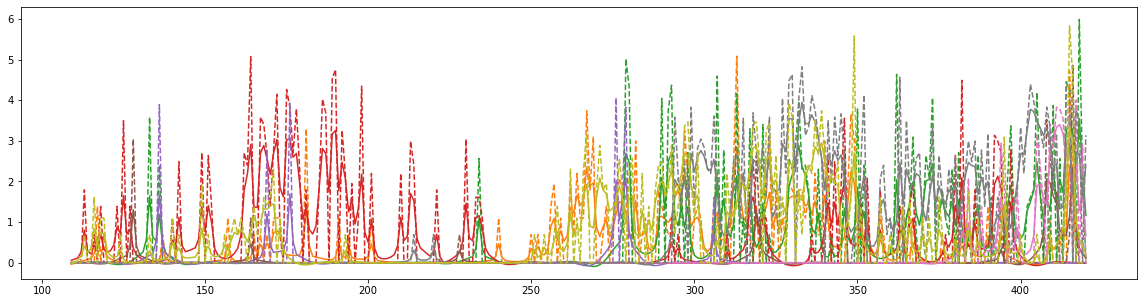

In [10]:
plot_gids = np.random.choice(df.loc[df['log_best'] > 4, 'gid'].unique(), 8)
plt.figure(figsize =  [20,5])

for i, gid in enumerate(plot_gids):

    c = f'C{i+1}'

    timeline = df.loc[df['gid'] == gid, ['month_id', 'log_best', 'tce']]

    plt.plot(timeline['month_id'],timeline['log_best'], '--', c = c)
    plt.plot(timeline['month_id'],timeline['tce'], c = c)

plt.show()

289: 2004-01


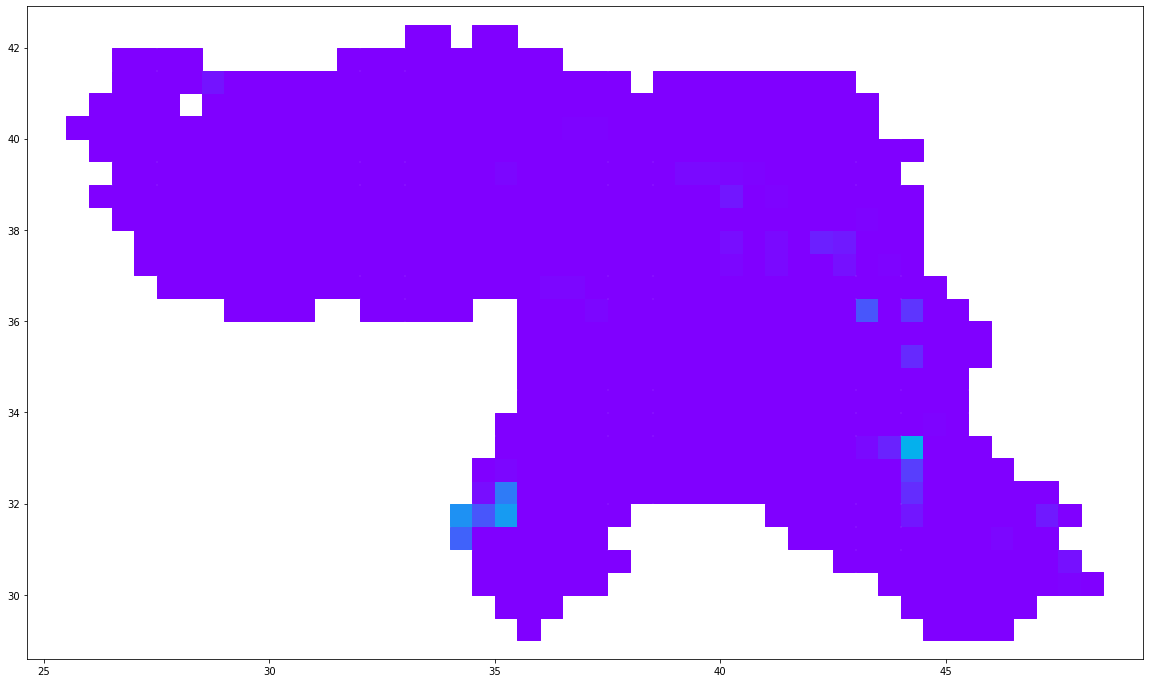

290: 2004-02


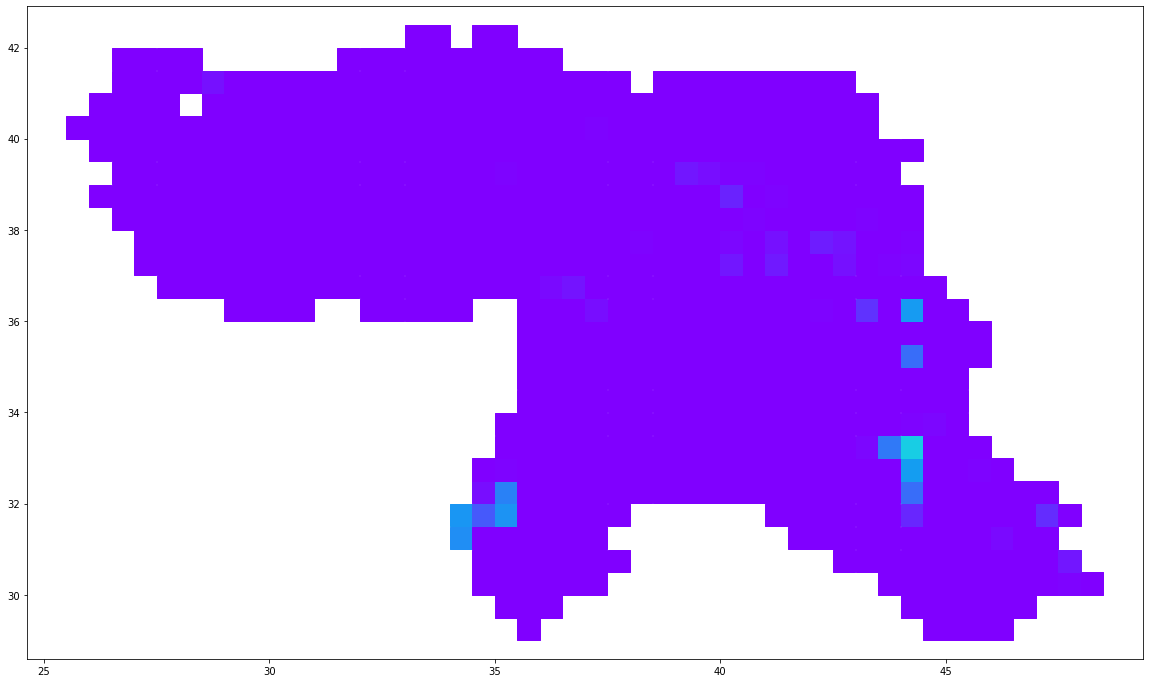

291: 2004-03


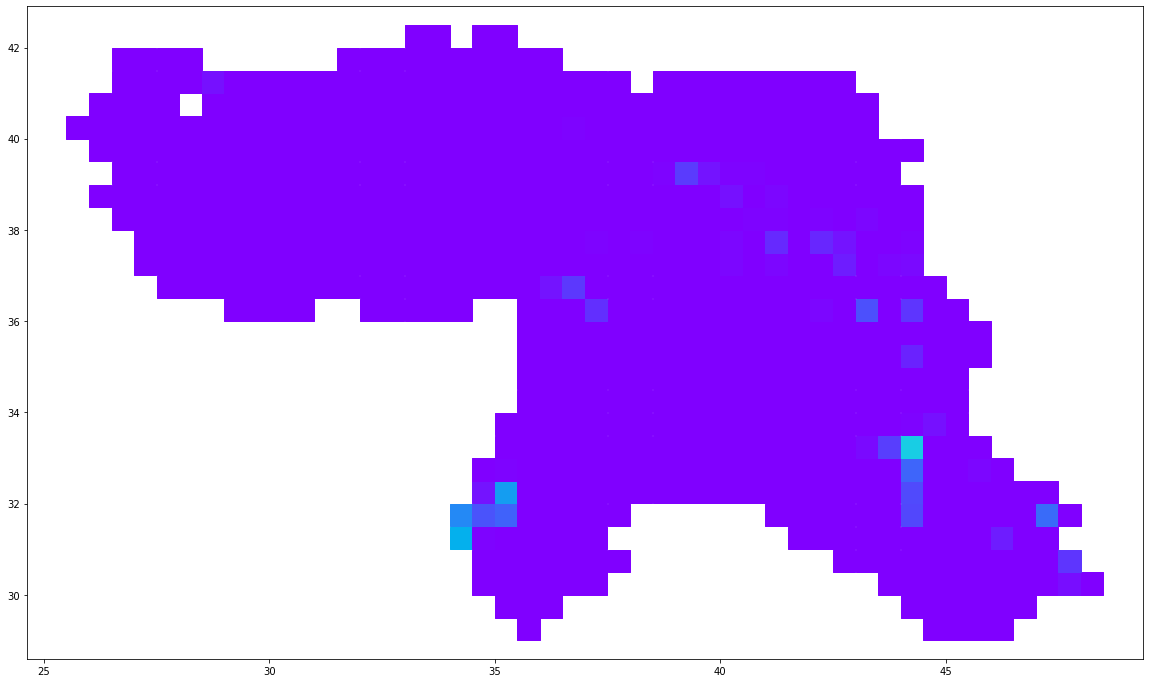

292: 2004-04


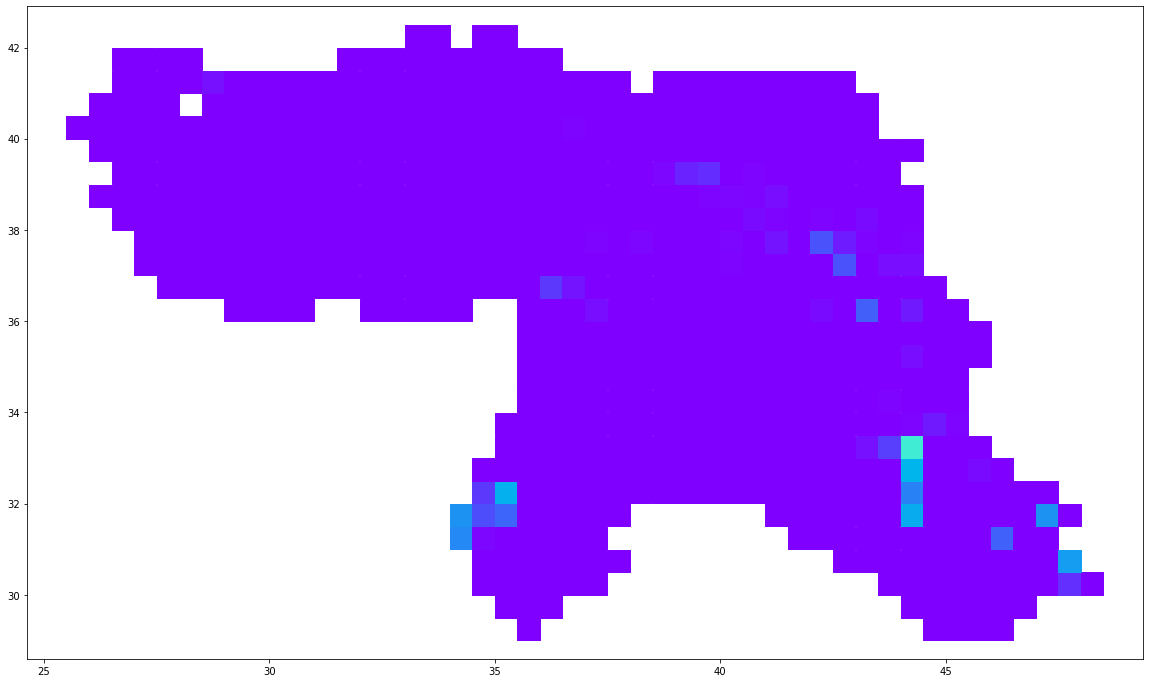

293: 2004-05


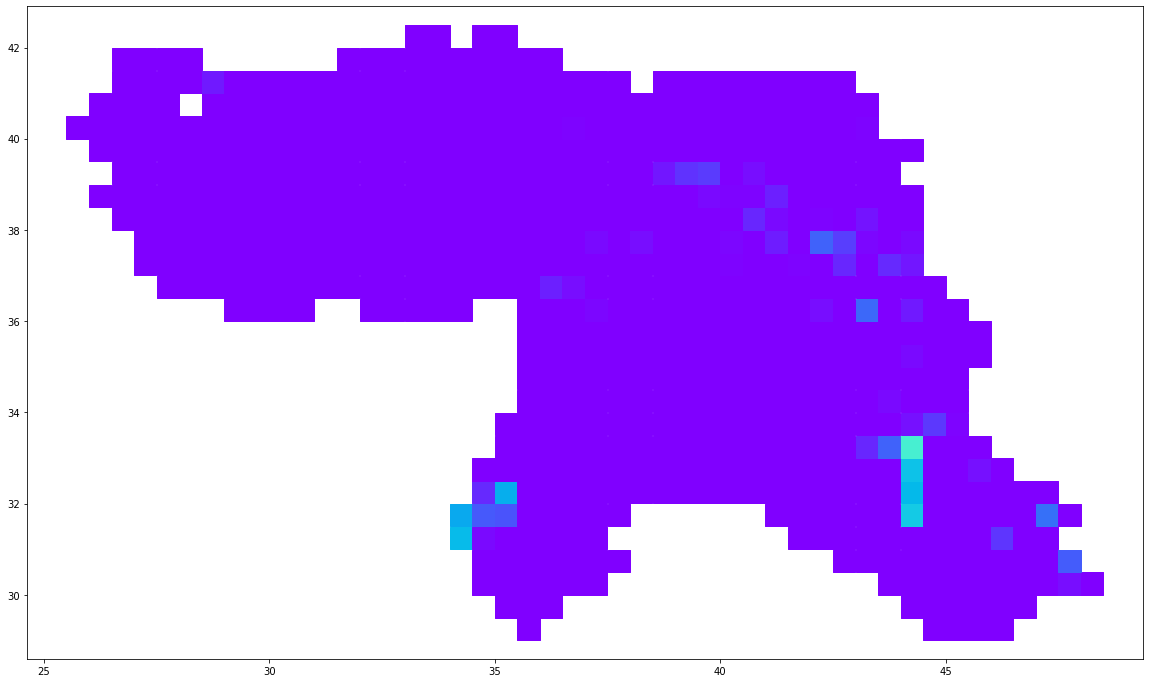

In [14]:
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
#sub_world = world[world['name'].isin(country_mask_world)].copy()

for i in sorted(df['month_id'].unique())[180:185]:

    print(f"{i}: {df[df['month_id'] == i]['year_months_start'].unique().item()}")

    plt.figure(figsize=[20,12])
    #fig, ax = plt.subplots(figsize = (20,20))

    #ax.set_aspect('equal')

    #vmax = combined_df['log_best'].max()
    vmax = df.loc[:,'log_best'].max()

    plt.scatter(df[df['month_id'] == i]['xcoord'], df[df['month_id'] == i]['ycoord'], c = df[df['month_id'] == i]['tce'], cmap = 'rainbow', marker = 's', s = 500,vmin = 0, vmax = vmax )

    #df[df['month_id'] == i].plot(ax = ax, column = 'tce', cmap = 'rainbow', vmin = 0, vmax = vmax)
    #sub_world.plot(facecolor='none', edgecolor='black', ax=ax)
    plt.show()

# Spatial

Damn... Should you just estimate a sample (5) with som amount of conflict and then just use fixed hps from those... Sound like a bette plan

In [15]:
# Critaria log_best > 4
sub_months = df[df['log_best'] > 4].groupby('month_id').count().sort_values('gid', ascending = False).iloc[:60,:].sample(5).index.values

In [16]:
noise_std = df['tce'].std()
kernel = ConstantKernel() * Matern(length_scale=0.5, length_scale_bounds=(0.1, 4.0), nu=1.5) + WhiteKernel(noise_level=noise_std)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

for month_id in sub_months:
    df_month = df[df['month_id'] == month_id].copy()
    y = np.array(df_month['tce']).reshape(-1,1)
    X = np.array(df_month[['xcoord', 'ycoord']]).reshape(-1,2)
    
    gaussian_process.fit(X, y)
    print(gaussian_process.kernel_)

0.729**2 * Matern(length_scale=0.838, nu=1.5) + WhiteKernel(noise_level=0.257)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.323**2 * Matern(length_scale=0.337, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.323**2 * Matern(length_scale=0.788, nu=1.5) + WhiteKernel(noise_level=0.134)
0.189**2 * Matern(length_scale=1.23, nu=1.5) + WhiteKernel(noise_level=0.0762)
0.723**2 * Matern(length_scale=1.38, nu=1.5) + WhiteKernel(noise_level=0.423)


In [17]:
gaussian_process.kernel_.get_params()

{'k1': 0.723**2 * Matern(length_scale=1.38, nu=1.5),
 'k2': WhiteKernel(noise_level=0.423),
 'k1__k1': 0.723**2,
 'k1__k2': Matern(length_scale=1.38, nu=1.5),
 'k1__k1__constant_value': 0.5233137649038104,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 1.3788504031095619,
 'k1__k2__length_scale_bounds': (0.1, 4.0),
 'k1__k2__nu': 1.5,
 'k2__noise_level': 0.4231356187506572,
 'k2__noise_level_bounds': (1e-05, 100000.0)}

In [18]:
amplitude = ConstantKernel(constant_value = 0.7**2, constant_value_bounds = 'fixed')
matern =  Matern(length_scale=0.5, nu=1.5, length_scale_bounds = 'fixed')
epsilon = WhiteKernel(noise_level=0.4, noise_level_bounds = 'fixed')

kernel = amplitude * matern + epsilon

gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

mean_prediction_list = []
std_prediction_list = []
gid_list = [] # for easy merge
month_id_list = [] # for easy merge
xcoord_list = []
ycoord_list = []
tce_list = []

for month_id in df['month_id'].unique():
    df_month = df[df['month_id'] == month_id].copy()
    y = np.array(df_month['tce']).reshape(-1,1)
    X = np.array(df_month[['xcoord', 'ycoord']]).reshape(-1,2)
    
    gaussian_process.fit(X, y)
    print(gaussian_process.kernel_)
    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

    mean_prediction_list.append(mean_prediction)
    std_prediction_list.append(std_prediction)
    gid_list.append(np.array(df_month['gid']))
    month_id_list.append(np.array(df_month['month_id']))
    xcoord_list.append(np.array(df_month['xcoord']))
    ycoord_list.append(np.array(df_month['ycoord']))
    tce_list.append(np.array(df_month['tce']))


0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKe

In [19]:
tsce_df = pd.DataFrame({'tsce':np.array(mean_prediction_list).ravel(), 
                        'tsce_std':np.array(std_prediction_list).ravel(), 
                        'gid':np.array(gid_list).ravel(), 
                        'month_id':np.array(month_id_list).ravel(),
                        'xcoord':np.array(xcoord_list).ravel(),
                        'ycoord': np.array(ycoord_list).ravel(),
                        'tce': np.array(tce_list).ravel()})

In [20]:
tsce_df

,tsce,tsce_std,gid,month_id,xcoord,ycoord,tce
0,1.228791e-05,0.776208,171792,109,35.75,29.25,0.0
1,1.721496e-06,0.769859,171810,109,44.75,29.25,0.0
2,2.667780e-06,0.763475,171811,109,45.25,29.25,0.0
3,3.854902e-06,0.763475,171812,109,45.75,29.25,0.0
4,5.145314e-06,0.769859,171813,109,46.25,29.25,0.0
...,...,...,...,...,...,...,...
206851,-2.062718e-07,0.769804,189793,420,36.25,41.75,0.0
206852,-2.295844e-09,0.769832,190507,420,33.25,42.25,0.0
206853,1.837542e-09,0.769522,190508,420,33.75,42.25,0.0
206854,-3.722545e-09,0.769522,190510,420,34.75,42.25,0.0


In [ ]:
for month_id in tsce_df['month_id'].unique():
    month_tsce_df = tsce_df[tsce_df['month_id'] == month_id]

    plt.figure(figsize = [14,8])
    plt.scatter(month_tsce_df['xcoord'], month_tsce_df['ycoord'], c =  month_tsce_df['tsce'], cmap = 'rainbow', marker = 's', s = 235, vmin = 0, vmax =  month_tsce_df['tsce'].max())
    plt.show()

In [27]:
merge_on = list(set.intersection(set(tsce_df.columns),set(df.columns)))

In [28]:
df_exposure = df.merge(tsce_df, how = 'left', on = merge_on)

In [29]:
df_exposure

,gid,xcoord,ycoord,col,row,year,gwno,month,year_months_start,month_id,...,prec_gpcp_observed,urban_ih_observed,cmr_mean,imr_mean,mountains_mean,ttime_mean,tce,tce_std,tsce,tsce_std
0,171792,35.75,29.25,432,239,1989,663.0,1,1989-01,109,...,True,False,10.96667,331.1458,0.523611,465.89420,0.0,0.702435,1.228791e-05,0.776208
1,171810,44.75,29.25,450,239,1989,645.0,1,1989-01,109,...,True,False,15.16667,662.5000,0.000000,522.95110,0.0,0.702435,1.721496e-06,0.769859
2,171811,45.25,29.25,451,239,1989,645.0,1,1989-01,109,...,True,False,15.40000,776.2500,0.000000,485.13830,0.0,0.702435,2.667780e-06,0.763475
3,171812,45.75,29.25,452,239,1989,645.0,1,1989-01,109,...,True,False,15.52222,835.8333,0.000000,446.73140,0.0,0.702435,3.854902e-06,0.763475
4,171813,46.25,29.25,453,239,1989,645.0,1,1989-01,109,...,True,False,15.63333,890.0000,0.000000,468.15780,0.0,0.702435,5.145314e-06,0.769859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206851,189793,36.25,41.75,433,264,2014,640.0,12,2014-12,420,...,False,False,4.80000,419.0000,0.000000,76.29713,0.0,0.702435,-2.062718e-07,0.769804
206852,190507,33.25,42.25,427,265,2014,640.0,12,2014-12,420,...,False,False,4.80000,419.0000,0.000000,206.66670,0.0,0.702435,-2.295844e-09,0.769832
206853,190508,33.75,42.25,428,265,2014,640.0,12,2014-12,420,...,False,False,4.80000,419.0000,0.000000,0.00000,0.0,0.702435,1.837542e-09,0.769522
206854,190510,34.75,42.25,430,265,2014,640.0,12,2014-12,420,...,False,False,4.80000,419.0000,0.000000,365.80190,0.0,0.702435,-3.722545e-09,0.769522


In [30]:
data_dir = '/home/simon/Documents/Bodies/data/PRIO/'
with open(f'{data_dir}full_interpl_df_exposure.pkl', 'wb') as file:
    pickle.dump(df_exposure, file)
            

- Make nice script
- Make plotting Script that do not break your puter
- Plot